In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
'''
In this fourth round of Prosperity a new luxury product is introduced: `MAGNIFICENT MACARONS`. `MAGNIFICENT MACARONS` are a delicacy and their value is dependent on all sorts of observable factors like hours of sun light, sugar prices, shipping costs, in- & export tariffs and suitable storage space. Can you find the right connections to optimize your program? 

Position limits for the newly introduced products:

- `MAGNIFICENT_MACARONS`: 75
- Conversion Limit for `MAGNIFICENT_MACARONS` = 10
'''

'''
1. ConversionObservation (detailed in “[Writing an Algorithm in Python](https://www.notion.so/Writing-an-Algorithm-in-Python-17be8453a09381988c6ed45b1b597049?pvs=21)” under E-learning center) shows quotes of `MAGNIFICENT_MACARONS` offered by the chefs from Pristine Cuisine
2. To purchase 1 unit of `MAGNIFICENT_MACARONS` from Pristine Cuisine, you will purchase at askPrice, pay `TRANSPORT_FEES` and `IMPORT_TARIFF`
3. To sell 1 unit of `MAGNIFICENT_MACARONS` to Pristine Cuisine, you will sell at bidPrice, pay `TRANSPORT_FEES` and `EXPORT_TARIFF`
4. You can ONLY trade with Pristine Cuisine via the conversion request with applicable conditions as mentioned in the wiki
5. For every 1 unit of `MAGNIFICENT_MACARONS` net long position, storage cost of 0.1 Seashells per timestamp will be applied for the duration that position is held. No storage cost applicable to net short position


we have to already be long / short earlier to be able to convert
can only convert at most to neutral at 0, not more than that

AKA we buy / sell from our own island
if position mispriced we sell to other island easily


Official Hint:

It was well understood lore in Archipelago that low sunlight index can impact sugar and MACARON production negatively causing prices to rise due to panic among residents. However, ArchiResearchers have identified existence of a CriticalSunlightIndex (CSI).

If sunlightindex goes below this CSI with an anticipation to remain under this critical level for a long period of time, sugar and MACARON prices can increase by substantial amount with a strong correlation.

When sunlightindex is above this CSI, Sugar and MACARON prices tend to trade around their respective fair values and demonstrates market supply-demand dynamics.

Can you find this CSI and use it to trade better than ever and make your island prosper? All the best!

'''

'''
Ideas:

- regression extrapolate on past sunlight trend and we'll soon know based on slope and rate of change per timestamp whehter we're heading below this threshold
- if we expect this, get into huge buy position and sell at the top
- if sunlight goes below this CSI then strong positive correlation between sugar prices and macaron
    - in this case we just do pairs trading with mean reversion when they deviate by a lot
- if above this csi, normal market supply-demand
    - normal market take / make used in kelp

'''


class Product:
    MACARONS = 'MAGNIFICENT_MACARONS'


In [3]:
prices = pd.concat([pd.read_csv(f'round4/prices_round_4_day_{i}.csv', sep=';') for i in range(1, 4)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round4/trades_round_4_day_{i}_nn.csv', sep=';') for i in range(1, 4)], ignore_index=True)
observations = []
for day in range(1, 4):
    odf = pd.read_csv(f'round4/observations_round_4_day_{day}.csv')
    odf['day'] = day
    observations.append(odf)
observations = pd.concat(observations, ignore_index=True)
observations = observations.rename({'bidPrice': 'islandBid', 'askPrice': 'islandAsk'}, axis=1)

In [4]:
macarons = prices[prices['product'] == Product.MACARONS].reset_index(drop=True).copy()

In [5]:
mk = observations.merge(macarons, on=['day', 'timestamp'])

In [6]:
mk['time'] = mk['timestamp'] + (mk['day'] - 1) * 1_000_000

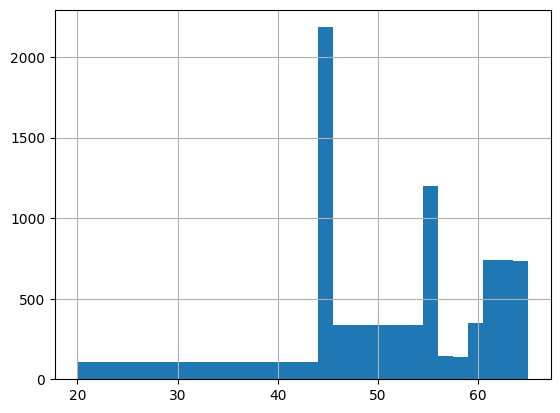

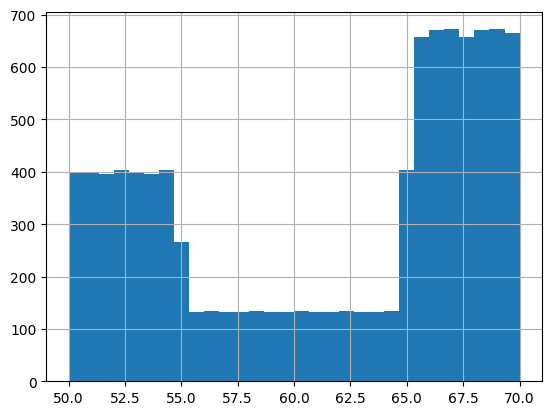

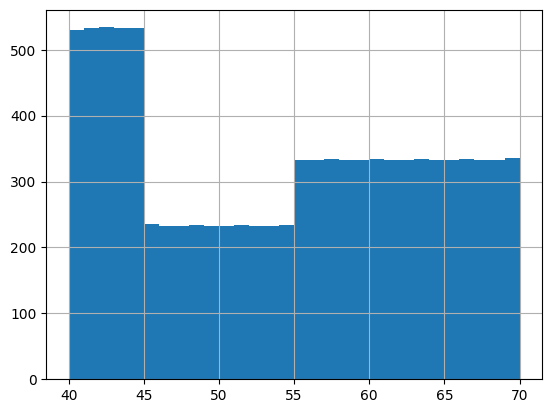

In [13]:
for d in [1, 2, 3]:
    df = mk[mk['day'] == d]
    df['sunlightIndex'].hist(bins=30)
    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

day_df = mk[mk['day'] == 1]

csi_guess = []
rs = []
coefs = []

for guess in range(20, 71, 1):
    df = day_df[day_df['sunlightIndex'] < guess]
    returns = df[['sugarPrice', 'mid_price']].rolling(20).mean().pct_change().dropna()

    if len(returns) < 30:
        continue

    model = LinearRegression()
    X = returns['sugarPrice'].to_numpy().reshape(-1, 1)
    y = returns['mid_price'].to_numpy()
    model.fit(X, y)
    
    r_squared = model.score(X, y)
    coef = model.coef_[0]
    
    coefs.append(coef)
    csi_guess.append(guess)
    rs.append(r_squared)

/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_61334/2936816318.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[['sugarPrice', 'mid_price']].rolling(10).mean().rolling(10).mean().pct_change(3).dropna()


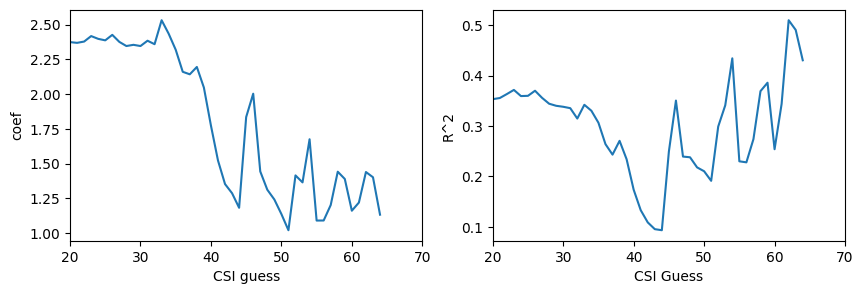

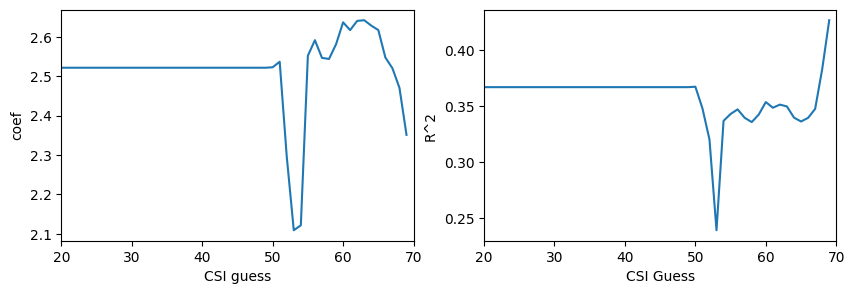

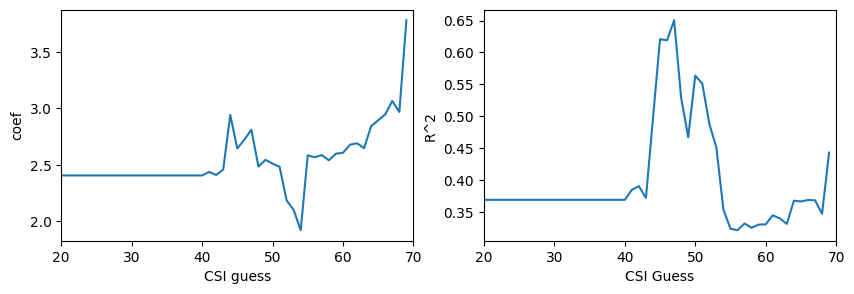

In [66]:
from sklearn.utils import resample

for day in [1, 2, 3]:
    day_df = mk[mk['day'] == day]

    csi_guess = []
    rs = []
    coefs = []

    for guess in range(20, 71, 1):
        df = day_df[day_df['sunlightIndex'] > guess]
        returns = df[['sugarPrice', 'mid_price']].rolling(10).mean().rolling(10).mean().pct_change(3).dropna()

        if len(returns) < 30:
            if len(returns) == 0:
                continue  # Skip if returns is empty
            # Oversample the data to ensure sufficient length
            returns = resample(returns, replace=True, n_samples=30, random_state=42)

        model = LinearRegression()
        X = returns['sugarPrice'].to_numpy().reshape(-1, 1)
        y = returns['mid_price'].to_numpy()
        model.fit(X, y)
        
        r_squared = model.score(X, y)
        coef = model.coef_[0]
        
        coefs.append(coef)
        csi_guess.append(guess)
        rs.append(r_squared)

    plt.figure(figsize=(10, 3))

    # plot coef vs guess
    plt.subplot(1, 2, 1)
    plt.plot(csi_guess, coefs)
    plt.xlabel('CSI guess')
    plt.ylabel('coef')
    plt.xlim(20, 70)  # Set x-axis limits

    # plot rs vs csi_guess
    plt.subplot(1, 2, 2)
    plt.plot(csi_guess, rs)
    plt.xlabel('CSI Guess')
    plt.ylabel('R^2')
    plt.xlim(20, 70)  # Set x-axis limits
    plt.show()

<Axes: >

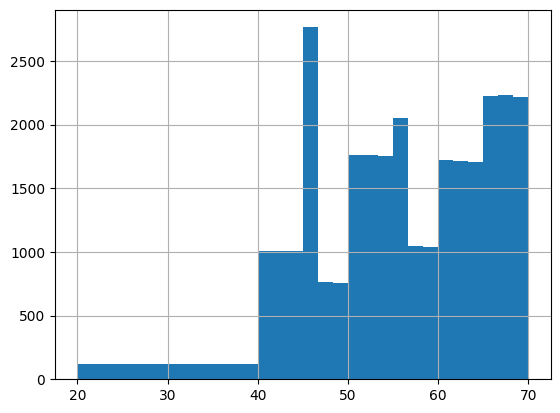

In [ ]:
synthetic = mk[['sunlightIndex', 'sugarPrice', 'mid_price']].copy()

mk['sunlightIndex'].hist(bins=30)




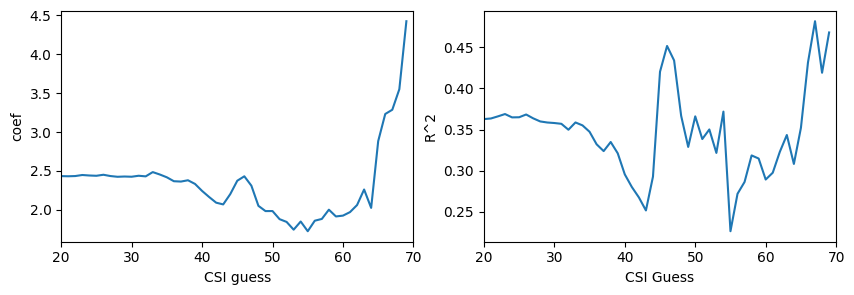

In [65]:
from sklearn.utils import resample


day_df = mk

csi_guess = []
rs = []
coefs = []

for guess in range(20, 71, 1):
    df = day_df[day_df['sunlightIndex'] > guess]
    returns = df[['sugarPrice', 'mid_price']].rolling(10).mean().rolling(10).mean().pct_change(3).dropna()

    if len(returns) < 30:
        if len(returns) == 0:
            continue  # Skip if returns is empty
        # Oversample the data to ensure sufficient length
        returns = resample(returns, replace=True, n_samples=30, random_state=42)

    model = LinearRegression()
    X = returns['sugarPrice'].to_numpy().reshape(-1, 1)
    y = returns['mid_price'].to_numpy()
    model.fit(X, y)
    
    r_squared = model.score(X, y)
    coef = model.coef_[0]
    
    coefs.append(coef)
    csi_guess.append(guess)
    rs.append(r_squared)

plt.figure(figsize=(10, 3))

# plot coef vs guess
plt.subplot(1, 2, 1)
plt.plot(csi_guess, coefs)
plt.xlabel('CSI guess')
plt.ylabel('coef')
plt.xlim(20, 70)  # Set x-axis limits

# plot rs vs csi_guess
plt.subplot(1, 2, 2)
plt.plot(csi_guess, rs)
plt.xlabel('CSI Guess')
plt.ylabel('R^2')
plt.xlim(20, 70)  # Set x-axis limits
plt.show()

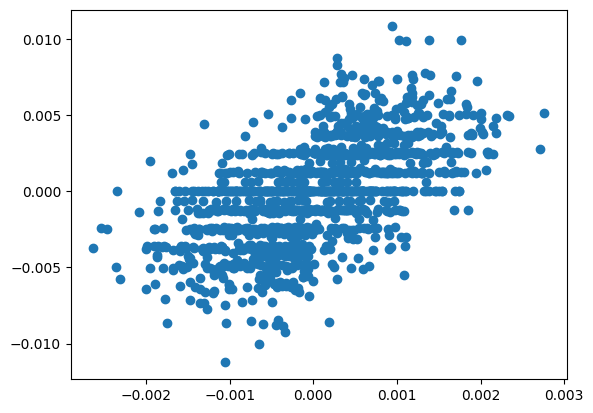

In [120]:
# 40 - 60

low_sun_df = mk[(0 <  mk['sunlightIndex']) & (mk['sunlightIndex'] < 40)]
plt.scatter(low_sun_df['sugarPrice'].pct_change(), low_sun_df['mid_price'].pct_change())
plt.show()

In [121]:
model = LinearRegression()
X = low_sun_df['sugarPrice'].pct_change().dropna().to_numpy().reshape(-1, 1)
y = low_sun_df['mid_price'].pct_change().dropna().to_numpy()
model.fit(X, y)
print('Equation:', model.coef_[0], 'x +', model.intercept_)

Equation: 2.2756650754884564 x + -0.00013328483626100205
